This notebook is for developing the tools to crop WSI into tissues based on annotated bounding boxes instead of using tissue_finder. Will crop polygons.

Author: Jesse T. Chao
Contact: jesse.chao@sri.utoronto.ca

In [1]:
import glob
import json
import os
from typing import Dict, Tuple, List, Set, Iterator
import multiprocessing as mp

import numpy as np
import tifffile as tf
import matplotlib
import matplotlib.pyplot as plt
# Uncomment to switch matplotlib and plt backend to an interactive one, e.g., TkAgg NOTE only necessary in certain dev envs like WSL
#matplotlib.use("TkAgg", force=True)
#plt.switch_backend("TkAgg")
#print("Switching plotting backend to:", matplotlib.get_backend())
%matplotlib inline
from matplotlib import patches
from detectron2.data import transforms as T

#import project_path
from utils import AnnoUtil, TrainUtil, channel_last, scale_bboxes, resize_image

# Helper functions

In [2]:
def vis_boxes(image, bboxes, box_names=None):
    fig, ax = plt.subplots()
    N = len(bboxes) * 5
    cmap = plt.cm.get_cmap('hsv', N)
    # Pad image with border
    padded = np.pad(image, pad_width=((5,5), (5,5), (0,0)), mode='constant', constant_values=0)
    ax.imshow(padded)
    # Draw bbox over all kept contours
    for i in range(len(bboxes)):
        x1, y1, x2, y2 = bboxes[i]
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle(
                    (x1, y1), width, height, linewidth=1, edgecolor=cmap(i), facecolor='none'
                )
        ax.add_patch(rect)
        if box_names:
            ax.annotate(box_names[i], (x1, y1), color=cmap(i), ha="left", va="top")
    plt.show(); plt.close()

In [3]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [4]:
def get_bbox(poly):
    x = poly[0::2]
    y = poly[1::2]
    return np.min(x), np.min(y), np.max(x), np.max(y)

def get_polygon(poly):
    x = poly[0::2]
    y = poly[1::2]
    return np.array(list(zip(x, y)))

# Experiment on a single image

This image has 9 pages, 9 levels:
(210579, 94968, 3)
(105289, 47484, 3)
(52644, 23742, 3)
(26322, 11871, 3)
(13161, 5935, 3)
(6580, 2967, 3)
(3290, 1483, 3)
(1645, 741, 3)
(822, 370, 3)


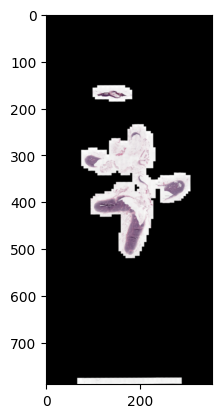

In [12]:
#src_dir = "/mnt/d/SynologyDrive/SRI_OSCC_lymph_test" # WSL
#src_dir = "/mnt/MT8/SynologyDrive/SRI_OSCC_lymph_test" # Linux
src_dir = '/mnt/RSX/Datasets_pathology/SRI_OSCC_lymph_labeled'
image_id = "Case 14 F11"
image_ext = ".svs"
image_file = os.path.join(src_dir, image_id+image_ext)
max_dim = 800
# Read WSI header and get some info
with tf.TiffFile(image_file) as slide:
    print(
        f"This image has {len(slide.pages)} pages, {len(slide.series[0].levels)} levels:"
    )
    for i in slide.series[0].levels:
        print(i.shape)
    # Get image thumbnail
    image_thumbnail = TrainUtil(max_dim).find_top(slide)
    # Set image dimension attributes
    target_dim = image_thumbnail.shape
    base_dim = slide.series[0].levels[0].shape
    base_dim = channel_last(base_dim)
    # Display image
    fig, ax = plt.subplots()
    ax.imshow(image_thumbnail)
    plt.show(); plt.close()

In [13]:
# Read annotations
annos_dir = os.path.join(src_dir, "qupath_annotations_latest")
anno_helper = AnnoUtil(os.path.join(annos_dir, image_id+".json"))
image_annotations = anno_helper.image_annotations

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/RSX/Datasets_pathology/Cam17_train/qupath_annotations_latest/patient_000_node_3.json'

In [ ]:
# First, find tissue annos
annos = []
print("Found the following annotations:")
if type(image_annotations) == dict:
    image_annotations = [image_annotations]
for i in image_annotations:
    # Get box name, check if valid box
    box_name = anno_helper.get_box_name(i)
    if box_name:
        if "lymph" in box_name:
            # Get box dict
            box_dict = anno_helper.find_bbox_coordinates(i)
            annos.append(box_dict)
print(annos)

In [ ]:
for i in anno_helper.image_annotations:
    print(anno_helper.get_box_name(i))

In [ ]:
# Visualize tissue boxes
scaled_annos = anno_helper.scale_bbox_dicts(annos, base_dim, target_dim)
box_names = []
boxes = []
for anno in scaled_annos:
    for name, box in anno.items():
        box_names.append(name)
        boxes.append(box)
vis_boxes(image_thumbnail, boxes, box_names)

In [ ]:
# Second, find lesion annos polygons
# TODO for @ben write these into util functions
lesions = []
for i in image_annotations:
    # Check if polygon
    num_vertices = len(next(anno_helper.search_recursive(i, "coordinates"))[0])
    if num_vertices > 5:
        # Get polygon name
        properties = next(anno_helper.search_recursive(i, "properties"))
        poly_name = properties["classification"]["name"].lower()
        # Get polygon coords
        poly_coords = next(anno_helper.search_recursive(i, "coordinates"))[0]
        # Get polygon dict
        poly_dict = {poly_name: poly_coords}
        lesions.append(poly_dict)
    else:
        continue
print(f"Found {len(lesions)} lesion annotations:")
for i in lesions:
    for key, values in i.items():
        print(f"Lesion class: '{key}', number of points for polygon = {len(values)}")
#print(lesions)


In [ ]:
out_dir = '/home/chao_lab/SynologyDrive/chaolab_AI_path/lesion_finder/test_outputs'

In [ ]:
# Crop out each tissue

with tf.TiffFile(image_file) as slide:
    # Process each tissue
    for n, a in enumerate(annos):
        print(f"Processing tissue number {n}:")
        # Calculate cropped tissue dimensions at each level of the image pyramid
        for k, v in a.items():
            tissue_name = k
            tissue_coords_base = v
            tx1, ty1, tx2, ty2 = tissue_coords_base
            base_long_edge = max(tx2-tx1, ty2-ty1)
            #print("    ", f"annotation is '{k}'")
        if len(slide.series[0].levels) > 1:
            pyramid_reader = slide.series[0].levels
        else:
            pyramid_reader = slide.pages
        for level_idx, level in enumerate(pyramid_reader):
            level_dim = train_utils.channel_last(level.shape)
            level_crop = train_utils.scale_bboxes([tissue_coords_base], base_dim, level_dim)[0]
            cx1, cy1, cx2, cy2 = [int(i) for i in level_crop]
            crop_w = cx2-cx1
            crop_h = cy2-cy1
            crop_long_edge = max(crop_w, crop_h)
            #print("    ", f"Testing cropping at 'level {level_idx}' ({level_dim[0]}x{level_dim[1]})...")
            #print("        ", f"the longest edge in the current crop is {crop_long_edge}px")
            if crop_h>max_dim or crop_w>max_dim:
                target_level = level_idx
                continue
            else:
                target_level = level_idx - 1
                break
        #print("    ", f"=> will need to read from 'level {target_level}' for this tissue")
        # Read image at the correct level
        #print("    ", f"Reading and cropping image to {max_dim}px...")
        input_image = pyramid_reader[target_level].asarray()
        input_image = train_utils.channel_last(input_image)
        # Recrop image NOTE CropTransform needs input in XYWH
        recrop_coord = train_utils.scale_bboxes([tissue_coords_base], base_dim, input_image.shape)[0]
        rx1, ry1, rx2, ry2 = [int(i) for i in recrop_coord]
        recropper = T.CropTransform(rx1, ry1, rx2-rx1, ry2-ry1)
        recropped_tissue = recropper.apply_image(input_image)
        # Resize crop if necessary
        if recropped_tissue.shape[0]>max_dim or recropped_tissue.shape[1]>max_dim:
           # print("        ", 
                 # f"this tissue crop is bigger than {max_dim}px",
                 #  "and will be downsampled")
            recropped_tissue = train_utils.resize_image(recropped_tissue, max_dim)
        #else:
           # print("        ", "done!")
        new_long_edge = max(recropped_tissue.shape[0], recropped_tissue.shape[1])
        scale_factor = round(new_long_edge/ base_long_edge, 3)
        
        # Scale and offset lesion annotations (polygons) to tissue
        #print("    ", "Resizing lesion annotations (polygons)...")
        processed_polygons = []
        poly_bboxes = []
        for le in lesions:
            for k, v in le.items():
                polygon = np.array(v)
            # Scaling
            scaled_polygon = np.multiply(polygon, scale_factor)          
            # Offsetting
            tx1, ty1, tx2, ty2 = tissue_coords_base
            tissue_offset = np.array([[tx1, ty1]])
            offset_polygon = np.subtract(
                scaled_polygon, 
                np.tile(tissue_offset*scale_factor, (scaled_polygon.shape[0], 1))
                )
            offset_x = np.max([i[0] for i in offset_polygon])
            offset_y = np.max([i[1] for i in offset_polygon])
            # Drop out-of-bounds polygons
            if np.any(offset_y>recropped_tissue.shape[0]) or \
                np.any(offset_x>recropped_tissue.shape[1]) or \
                np.any(offset_polygon<0): 
                continue
            # Drop open polygons
            if not np.array_equal(offset_polygon[0], offset_polygon[-1]):
                #print("        ", "dropped an open polygon")
                continue
            else:
                processed_polygons.append(offset_polygon) 
                # Get bbox for each polygon
                poly_bbox = get_bbox(offset_polygon)
                poly_bboxes.append(poly_bbox)
    
        # Visualize
       # print("    ", "Visualizing...")
       # fig, ax = plt.subplots()
        #ax.imshow(recropped_tissue)  
       # for poly in processed_polygons:
          #  ax.plot(poly[:, 0], poly[:, 1])
            
       # plt.show(); plt.close()

        # Round to int and flatten
        processed_polygons = ([np.round(i).astype(int) for i in processed_polygons])
        processed_polygons = ([i.flatten() for i in processed_polygons])
        
        # For each tissue, save to disk with annotations in json
        print("    ", "Saving to disk...")
        np.save(os.path.join(out_dir, f"{image_id}_{n}.npy"), recropped_tissue)
        #Create annotation dict
        annotation_dicts = []
        for poly in processed_polygons:
            poly_bbox = get_polygon(poly)
            annnotation_dict = {
                "category_id" : 0, # TODO: Change this based on class conversions
                "bbox" : poly_bbox,
                "bbox_mode" : 0,
                "segmentation" : [poly]
            }
            annotation_dicts.append(annnotation_dict)
            
        print(len(annotation_dicts))
            
            
        tissue_anno_dict = {
            "file_name": image_file,
            "tissue_xyxy" : tissue_coords_base,
            "image_width" : recropped_tissue.shape[1],
            "image_height" : recropped_tissue.shape[0],
            "max_dim": max_dim,
            "annotations": annotation_dicts
        }
        if not os.path.exists(os.path.join(out_dir, 'tissue_annotations')):
            os.makedirs(os.path.join(out_dir, 'tissue_annotations'))
        anno_json = json.dumps(tissue_anno_dict, indent = 4, cls=NpEncoder)
        with open(os.path.join(out_dir, 'tissue_annotations', f"{image_id}_{n}.json"), 'w') as j:
            j.write(anno_json)

# Batch process

In [6]:
def process_tissue_annos(class_conv, image_file, annos, lesions, max_dim, base_dim, out_dir):
    image_id = os.path.basename(image_file).split(".")[0]
    with tf.TiffFile(image_file) as slide:
        # Process each tissue
        for n, a in enumerate(annos):
            # Calculate cropped tissue dimensions at each level of the image pyramid
            for k, v in a.items():
                tissue_name = k
                tissue_coords_base = v
                tx1, ty1, tx2, ty2 = tissue_coords_base
                base_long_edge = max(tx2-tx1, ty2-ty1)
            # print("    ", f"annotation is '{k}'")
            if len(slide.series[0].levels) > 1:
                pyramid_reader = slide.series[0].levels
            else:
                pyramid_reader = slide.pages
            for level_idx, level in enumerate(pyramid_reader):
                level_dim = train_utils.channel_last(level.shape)
                level_crop = train_utils.scale_bboxes([tissue_coords_base], base_dim, level_dim)[0]
                cx1, cy1, cx2, cy2 = [int(i) for i in level_crop]
                crop_w = cx2-cx1
                crop_h = cy2-cy1
                if crop_h>max_dim or crop_w>max_dim:
                    target_level = level_idx
                    continue
                else:
                    target_level = level_idx - 1
                    break
            # Read image at the correct level
            input_image = pyramid_reader[target_level].asarray()
            input_image = train_utils.channel_last(input_image)
            # Recrop image NOTE CropTransform needs input in XYWH
            recrop_coord = train_utils.scale_bboxes([tissue_coords_base], base_dim, input_image.shape)[0]
            rx1, ry1, rx2, ry2 = [int(i) for i in recrop_coord]
            recropper = T.CropTransform(rx1, ry1, rx2-rx1, ry2-ry1)
            recropped_tissue = recropper.apply_image(input_image)
            # Resize crop if necessary
            if recropped_tissue.shape[0]>max_dim or recropped_tissue.shape[1]>max_dim:
                #print("        ", 
                    #f"this tissue crop is bigger than {max_dim}px",
                    #"and will be downsampled")
                recropped_tissue = train_utils.resize_image(recropped_tissue, max_dim)
            #else:
                #print("        ", "done!")
            new_long_edge = max(recropped_tissue.shape[0], recropped_tissue.shape[1])
            scale_factor = round(new_long_edge/ base_long_edge, 3)
            
            # Scale and offset lesion annotations (polygons) to tissue
            #print("    ", "Resizing lesion annotations (polygons)...")
            processed_polygons = []
            polygon_names = []
            poly_bboxes = []
            for le in lesions:
                for k, v in le.items():
                    polygon = np.array(v)
                    polygon_names.append(k)
                # Scaling
                scaled_polygon = np.multiply(polygon, scale_factor)          
                # Offsetting
                tx1, ty1, tx2, ty2 = tissue_coords_base
                tissue_offset = np.array([[tx1, ty1]])
                offset_polygon = np.subtract(
                    scaled_polygon, 
                    np.tile(tissue_offset*scale_factor, (scaled_polygon.shape[0], 1))
                    )
                offset_x = np.max([i[0] for i in offset_polygon])
                offset_y = np.max([i[1] for i in offset_polygon])
                
                if np.any(offset_y>recropped_tissue.shape[0]) or \
                    np.any(offset_x>recropped_tissue.shape[1]) or \
                    np.any(offset_polygon<0): 
                    continue
                if not np.array_equal(offset_polygon[0], offset_polygon[-1]): # Drop open polygons
                    #print("        ", "dropped an open polygon")
                    continue
                else:
                    processed_polygons.append(offset_polygon) 
                    # Get bbox for each polygon
                    poly_bbox = get_bbox(offset_polygon)
                    poly_bboxes.append(poly_bbox)
                    
            if not os.path.exists(os.path.join(out_dir, 'visualizations')):
                os.makedirs(os.path.join(out_dir, 'visualizations'))
                        
            # Visualize
            fig, ax = plt.subplots()
            ax.imshow(recropped_tissue)  
            for poly in processed_polygons:
                ax.plot(poly[:, 0], poly[:, 1])
            plt.savefig(os.path.join(out_dir, 'visualizations', f'{image_id}_{n}.png'))
            plt.close()
            
            # Round to int and flatten
            processed_polygons = ([np.round(i).astype(int) for i in processed_polygons])
            processed_polygons = ([i.flatten() for i in processed_polygons])

             # For each tissue, save to disk with annotations in json
            print("    ", "Saving to disk...")
            np.save(os.path.join(out_dir, f"{image_id}_{n}.npy"), recropped_tissue)
            #Create annotation dict
            annotation_dicts = []
            for c, poly in enumerate(processed_polygons):
                if polygon_names[c].lower() in class_conv['non-neoplastic']:
                    num = 0
                elif polygon_names[c].lower() in class_conv['neoplastic']:
                    num = 1
                elif polygon_names[c].lower() in class_conv['ignore']:
                    num = 2
                else:
                    continue                  
                poly_bbox = get_bbox(poly)
                annnotation_dict = {
                    "category_id" : num, # TODO: Change this based on class conversions
                    "bbox" : poly_bbox,
                    "bbox_mode" : 0,
                    "segmentation" : [poly]
                }
                annotation_dicts.append(annnotation_dict)
                
                
                
            tissue_anno_dict = {
                "file_name": f"{image_file.split('.')[0]}_{n}.npy",
                "image_id": f"{image_id}_{n}",
                "original_width" : base_dim[1],
                "original_height" : base_dim[0],
                "tissue_xyxy" : tissue_coords_base,
                "width" : recropped_tissue.shape[1],
                "height" : recropped_tissue.shape[0],
                "max_dim": max_dim,
                "annotations": annotation_dicts
            }
            if not os.path.exists(os.path.join(out_dir, 'tissue_annotations')):
                os.makedirs(os.path.join(out_dir, 'tissue_annotations'))
            anno_json = json.dumps(tissue_anno_dict, indent = 4, cls=NpEncoder)
            with open(os.path.join(out_dir, 'tissue_annotations', f"{image_id}_{n}.json"), 'w') as j:
                j.write(anno_json)
        return

In [7]:
def lesion_finder_gt(src_dir, out_dir, image_path, max_dim, annos_dir):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    image_id = image_path.split('/')[-1].split('.')[0]
    image_ext = '.' + image_path.split('/')[-1].split('.')[1]
    image_file = os.path.join(src_dir, image_id+image_ext)
        
    # Read WSI header and get some info
    with tf.TiffFile(image_file) as slide:
        # Set image dimension attributes
        try:
            base_dim = slide.series[0].levels[0].shape
            base_dim = train_utils.channel_last(base_dim)
        except:
            # load image
            image = tf.imread(image_file)
            base_dim = train_utils.channel_last(image.shape)        
        
    # Read annotations
    anno_helper = train_utils.AnnoUtil(os.path.join(annos_dir, image_id+".json"))
    image_annotations = anno_helper.image_annotations
    # Create tissue list and populate with tissue boxes
    annos = []
    # QuPath sometimes returns a dict instead of list of dicts
    if type(image_annotations) == dict:
        image_annotations = [image_annotations]
    for i in image_annotations:
        # Get box name, check if valid box
        box_name = anno_helper.get_box_name(i)
        if box_name:
            if "lymph" in box_name: # includes non-lymph by substring ## we changed this btw
                # Get box dict
                box_dict = anno_helper.find_bbox_coordinates(i)
                annos.append(box_dict)
    #Create lesion list and populate with polygons
    lesions = []
    for i in image_annotations:
        # Check if polygon
        num_vertices = len(next(anno_helper.search_recursive(i, "coordinates"))[0])
        if num_vertices > 5:
            # Get polygon name
            properties = next(anno_helper.search_recursive(i, "properties"))
            try:
                poly_name = properties["classification"]["name"].lower()
            except:
                poly_name = "ROI_neoplastic"
            # Get polygon coords
            poly_coords = next(anno_helper.search_recursive(i, "coordinates"))[0]
            # Get polygon dict
            poly_dict = {poly_name: poly_coords}
            lesions.append(poly_dict)
        else:
            continue
    #Execute processing function
    class_conversion_file = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/configs/class_conversions/neoplastic.json'
    
    with open(class_conversion_file) as f:
        class_conv = json.load(f)
    #try:
    process_tissue_annos(class_conv, image_file, annos, lesions, max_dim, base_dim, out_dir)
    #except:
    #    print(f"Failed to process {image_id}")
    return print(f"Finished processing {image_id}")

In [8]:
def unlabeled_max_dim(image_file, max_dim=2560):
    image_id = os.path.basename(image_file).split(".")[0]
    with tf.TiffFile(image_file) as slide:
        # Set image dimension attributes
        try:
            base_dim = slide.series[0].levels[0].shape
            base_dim = train_utils.channel_last(base_dim)
        except:
            # load image
            image = tf.imread(image_file)
            base_dim = train_utils.channel_last(image.shape)
        # Calculate cropped tissue dimensions at each level of the image pyramid
        if len(slide.series[0].levels) > 1:
            pyramid_reader = slide.series[0].levels
        else:
            pyramid_reader = slide.pages
        for level_idx, level in enumerate(pyramid_reader):
            level_dim = train_utils.channel_last(level.shape)
            if level_dim[0] > max_dim or level_dim[1] > max_dim:
                target_level = level_idx
                continue
            else:
                target_level = level_idx - 1
                break
        # Read image at the correct level
        input_image = pyramid_reader[target_level].asarray()
        input_image = train_utils.channel_last(input_image)
        # Scale to max_dim
        if input_image.shape[0]>max_dim or input_image.shape[1]>max_dim:
            output_image = train_utils.resize_image(input_image, max_dim)
            
        np.save(os.path.join(out_dir, f"{image_id}.npy"), output_image)
        return print(f"Finished processing {image_id}")

In [9]:
def box_at_max_dim(image_file, box, label, base_dim, target_dim, max_dim=2560):
    
    box = list(box)
    box_base = train_utils.scale_bboxes([box], target_dim, base_dim)[0]
    
    with tf.TiffFile(image_file) as slide:
        x1, y1, x2, y2 = box_base

        if len(slide.series[0].levels) > 1:
            pyramid_reader = slide.series[0].levels
        else:
            pyramid_reader = slide.pages
        for level_idx, level in enumerate(pyramid_reader):
            level_dim = train_utils.channel_last(level.shape)
            level_crop = train_utils.scale_bboxes([box_base], base_dim, level_dim)[0]
            cx1, cy1, cx2, cy2 = [int(i) for i in level_crop]
            crop_w = cx2-cx1
            crop_h = cy2-cy1
            crop_long_edge = max(crop_w, crop_h)
            
            if crop_h>max_dim or crop_w>max_dim:
                target_level = level_idx
                continue
            else:
                target_level = level_idx - 1
                break
            
        input_image = pyramid_reader[target_level].asarray()
        input_image = train_utils.channel_last(input_image)
        
        recrop_coord = train_utils.scale_bboxes([box_base], base_dim, input_image.shape)[0]
        rx1, ry1, rx2, ry2 = [int(i) for i in recrop_coord]
        recropper = T.CropTransform(rx1, ry1, rx2-rx1, ry2-ry1)
        recropped_tissue = recropper.apply_image(input_image)
        # Resize crop if necessary
        if recropped_tissue.shape[0]>max_dim or recropped_tissue.shape[1]>max_dim:
           # print("        ", 
                 # f"this tissue crop is bigger than {max_dim}px",
                 #  "and will be downsampled")
            recropped_tissue = train_utils.resize_image(recropped_tissue, max_dim)
            
        tissue_anno_dict = {
                "file_name": image_file,
                "image_width" : recropped_tissue.shape[1],
                "image_height" : recropped_tissue.shape[0],
                "max_dim": max_dim,
                "annotations": [
                    {
                        "category_id" : label,
                        "bbox" : [0, 0, recropped_tissue.shape[1], recropped_tissue.shape[0]],
                        "bbox_mode" : 0
                    }
                ]
        }
        
        return recropped_tissue, tissue_anno_dict

In [ ]:
src_dir = "/mnt/RSX/Datasets_pathology/SRI_OSCC_lymph_unlabeled/"
max_dim = 2560
annos_dir = os.path.join(src_dir, "qupath_annotations_latest") #oldlabels has old lymph non-lymph (use for BCCan... all not containing lymph)
out_dir = '/mnt/RSX/Datasets_pathology/GT_2023/LesionFinderMask/SRI_OSCC_lymph_unlabeled/'

In [ ]:
# for unlabeled
image_files = glob.glob(src_dir + '*.svs')
image_files = [i for i in image_files if 'Case' in i]
num_workers = 12
with mp.Pool(num_workers) as pool:
    pool.starmap(unlabeled_max_dim, [(i, max_dim) for i in image_files])

In [ ]:
num_workers = 12
with mp.Pool(num_workers) as pool:
    pool.starmap(lesion_finder_gt, [(src_dir, out_dir, data, max_dim, annos_dir) for data in glob.glob(src_dir + '*.svs')])